# Planning the spanish economy 

Let's begin importing the data in a dictionary for the periods we want to plan. The data has been saved from the excel files using the ``save_data.py`` script.

In [1]:
from pathlib import Path
from pickle import load

import numpy as np

from cybersyn import Economy, Ecology, TargetEconomy, TargetEcology


with Path('data', 'economy.pkl').open('rb') as f:
    economy_dict = load(f)
    economy = Economy(**economy_dict)

with Path('data', 'target_economy.pkl').open('rb') as f:
    target_economy_dict = load(f)
    target_economy = TargetEconomy(**target_economy_dict)

with Path('data', 'ecology.pkl').open('rb') as f:
    ecology_dict = load(f)
    ecology = Ecology(**ecology_dict)

with Path('data', 'target_ecology.pkl').open('rb') as f:
    target_ecology_dict = load(f)
    target_ecology = TargetEcology(**target_ecology_dict)

The data is aggregated into 110 products and 81 sectors:

In [2]:
economy.product_names[:5]

['1. Products of agriculture',
 '2. Live animals and animal products',
 '3. Agricultural and animal husbandry services',
 '4. Products of forestry, logging and related services',
 '5 .Fish and other fishing products; aquaculture products; support services to fishing']

In [3]:
economy.sector_names[:5]

['Crop and animal production, hunting and related service activities\n  ',
 'Forestry and logging',
 'Fishing and aquaculture',
 'Mining and quarrying',
 'Processing and preserving of meat and production of meat products']

In [4]:
ecology.pollutant_names

['1.- GEI - Gases de efecto invernadero (miles de toneladas de CO2 equivalente)',
 '1.1- CO2 - Dióxido de carbono (miles de toneladas de CO2 equivalente)',
 '1.2- CH4 - Metano (miles de toneladas de CO2 equivalente)',
 '1.3- N2O - Óxido nitroso (miles de toneladas de CO2 equivalente)',
 '1.4- PFC - Perfluorocarbonos o compuestos polifluorcarbonados (miles de toneladas de CO2 equivalente)',
 '1.5- HFC - Hidrofluorocarbonos o compuestos hidrogenofluorcarbonados (miles de toneladas de CO2 equivalente)',
 '1.6- SF6  - Hexafluoruro de azufre (miles de toneladas de CO2 equivalente)',
 '2.- GAC- Gases acidificantes (toneladas de SO2 equivalentes)',
 '2.1- SOx  - Óxidos de azufre (toneladas de SO2 equivalentes)',
 '2.2- NOx  - Óxidos de nitrógeno (toneladas de SO2 equivalentes)',
 '2.3- NH3  - Amoniaco (toneladas de SO2 equivalentes)',
 '3.- PRO3- Gases precursores de ozono troposférico (toneladas de COVNM equivalentes)',
 '3.1- COVNM - Compuestos orgánicos volátiles no metánicos (toneladas)']

## The plan

We will plan the economy for 6 periods with a horizon of 2 periods and revising the plan after 1 period (apply one periods and discard the other).

In [5]:
from cybersyn import OptimizePlan

periods = 6
horizon_periods = 2
revise_periods = 1

plan = OptimizePlan(
    periods = periods,
    horizon_periods = horizon_periods, 
    revise_periods = revise_periods,
    economy = economy,
    ecology = ecology
)

planned_economy, planned_ecology = plan(
    target_economy,
    target_ecology,
    init_surplus=target_economy.domestic[0] / 12,  # np.zeros(economy.products)
    init_export_deficit=0  
)

In [6]:
activity = np.array(planned_economy.activity).T
production = np.array(planned_economy.production).T
surplus = np.array(planned_economy.surplus).T
total_import = np.array(planned_economy.total_import).T
export_deficit = np.array(planned_economy.export_deficit)
worked_hours = np.array(planned_economy.worked_hours)
pollutants = np.array(planned_ecology.pollutants).T

## Visualizing the results

In [7]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

colors = plt.cm.nipy_spectral(np.linspace(0, 1, economy.products))

We planned for 3 years and the interpolation between them (mYEAR).

In [8]:
periods = ['2016', 'm2016', '2017', 'm2017', '2018', 'm2018', '2019']

### Production unit activity 

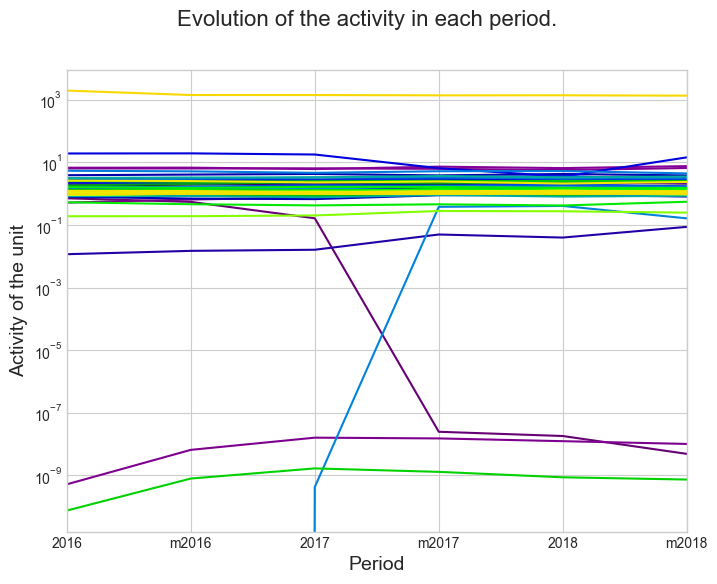

In [9]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of the activity in each period.', size = 16)

for i in range(economy.sectors):
    ax.plot(periods[: plan.periods], activity[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Activity of the unit', size = 14)
ax.set_yscale('log')

plt.savefig(Path('figures', 'unit_activity.png'))

### Production

The planned activity of each sector provides the planned production

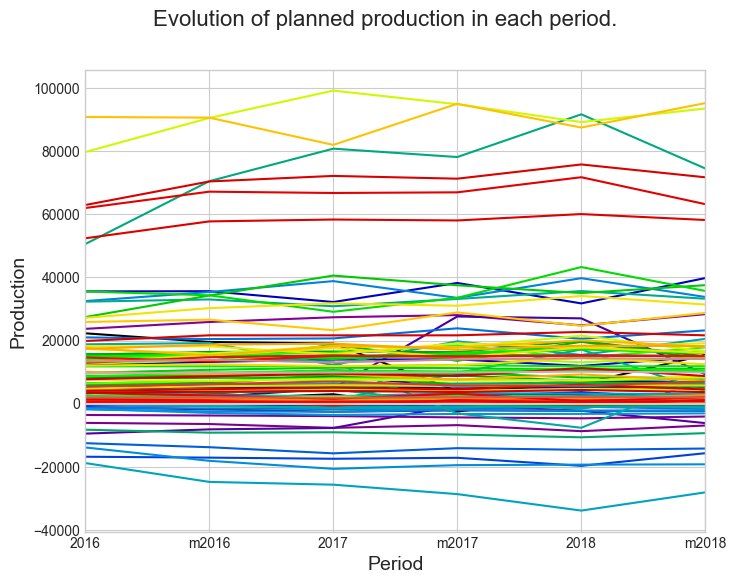

In [10]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of planned production in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], production[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Production', size = 14)

plt.savefig(Path('figures', 'planned_prod.png'))

Note that some periods have negative production. This means that either we are consuming excess goods from previous periods or, most likely, we are importing those producs.

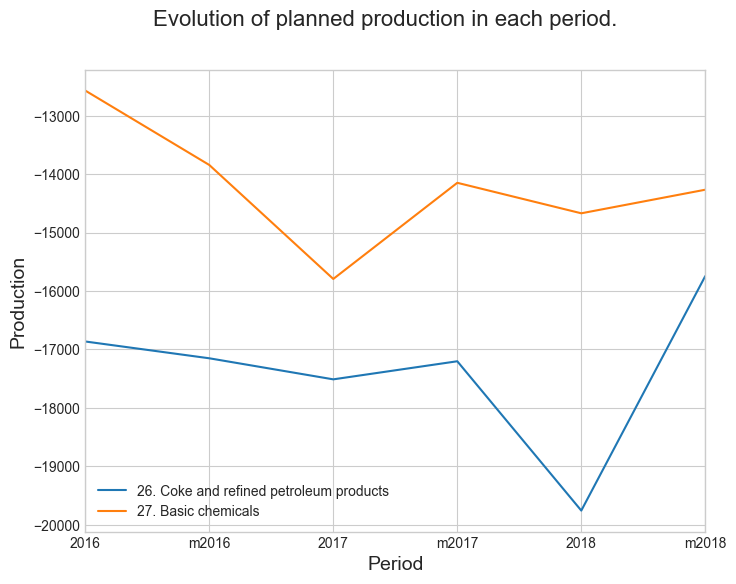

In [11]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of planned production in each period.', size = 16)

ax.plot(periods[: plan.periods], production[25, :], label=economy.product_names[25])
ax.plot(periods[: plan.periods], production[26, :], label='27. Basic chemicals')

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Production', size = 14)
ax.legend(loc="lower left")

### Excess production

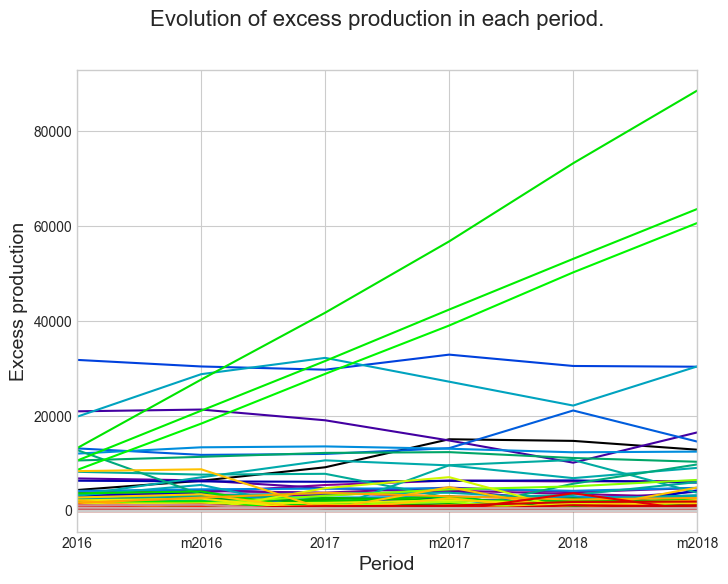

In [12]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of excess production in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], surplus[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Excess production', size = 14)

plt.savefig(Path('figures', 'excess_prod.png'))

Note how the excess of some products keeps rising

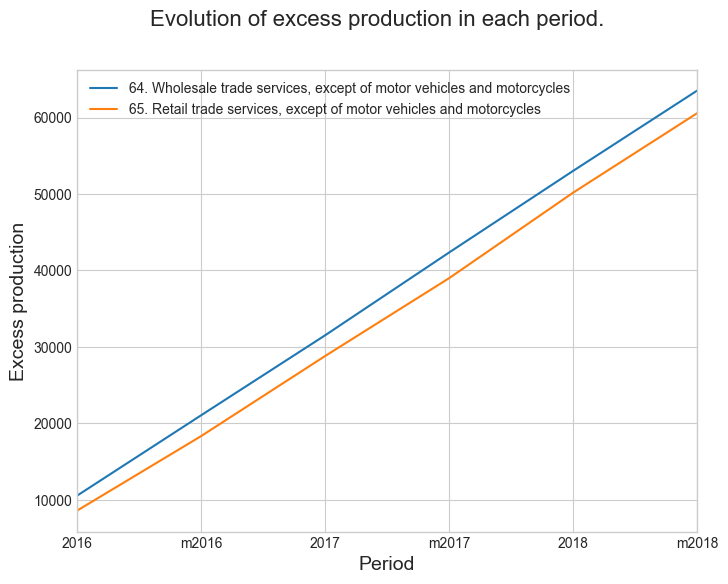

In [13]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of excess production in each period.', size = 16)

ax.plot(periods[: plan.periods], surplus[63, :], label=economy.product_names[63])
ax.plot(periods[: plan.periods], surplus[64, :], label=economy.product_names[64])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Excess production', size = 14)
ax.legend()

While others, like excess food, remains almost zero.

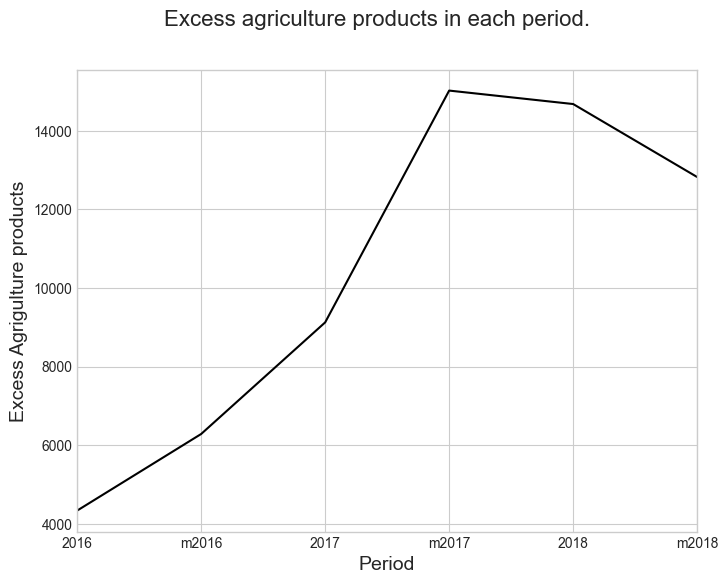

In [14]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle(r'Excess agriculture products in each period.', size = 16)

ax.plot(periods[: plan.periods], surplus[0, :], c=colors[0, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel("Excess Agrigulture products", size = 14)

plt.savefig(Path('figures', 'excess_agriculture.png'))

### Imported goods

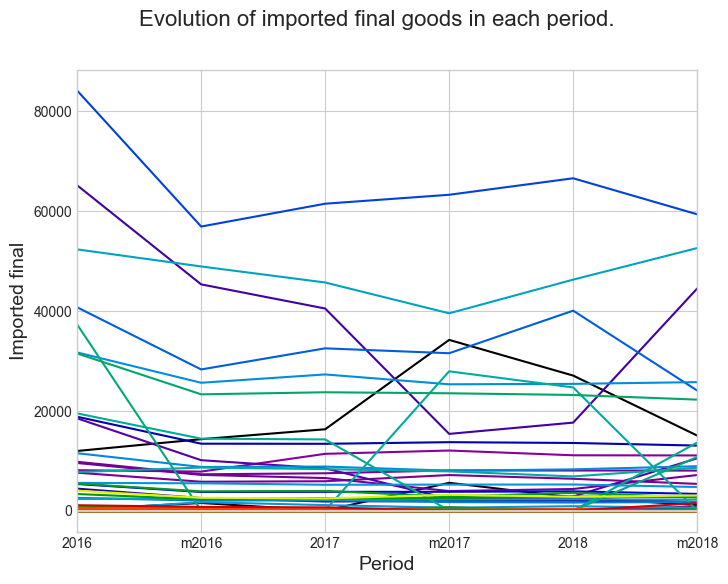

In [15]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of imported final goods in each period.', size = 16)

for i in range(economy.products):
    ax.plot(periods[: plan.periods], total_import[i, :], c=colors[i, :])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Imported final', size = 14)

plt.savefig(Path('figures', 'planned_prod.png'))

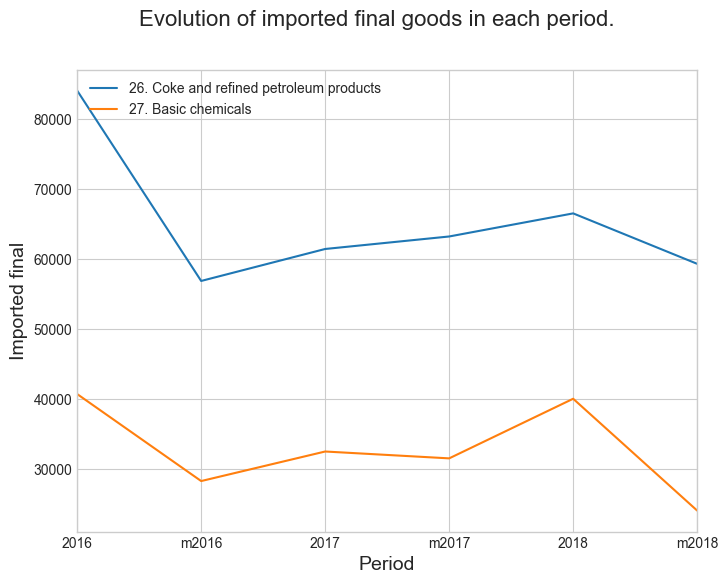

In [16]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Evolution of imported final goods in each period.', size = 16)

ax.plot(periods[: plan.periods], total_import[25, :], label=economy.product_names[25])
ax.plot(periods[: plan.periods], total_import[26, :], label='27. Basic chemicals')

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Imported final', size = 14)
ax.legend(loc="upper left")

### Export deficit

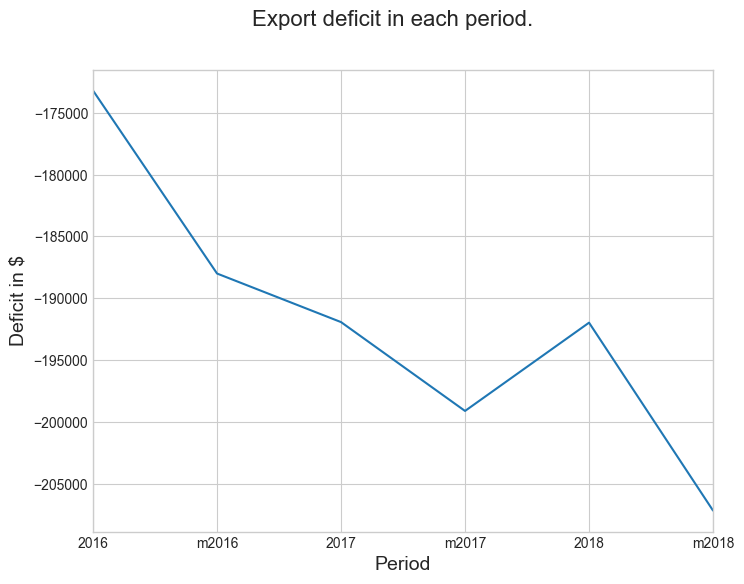

In [17]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Export deficit in each period.', size = 16)

ax.plot(periods[: plan.periods], export_deficit)

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Deficit in $', size = 14)

plt.savefig(Path('figures', 'export_deficit.png'))

### Total worked hours

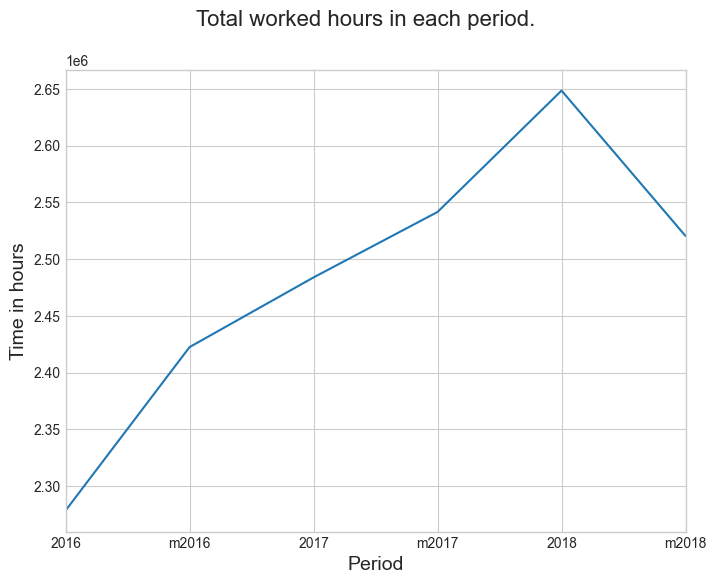

In [18]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Total worked hours in each period.', size = 16)

ax.plot(periods[: plan.periods], worked_hours)

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Time in hours', size = 14)

plt.savefig(Path('figures', 'worked_hours.png'))

### Pollutants

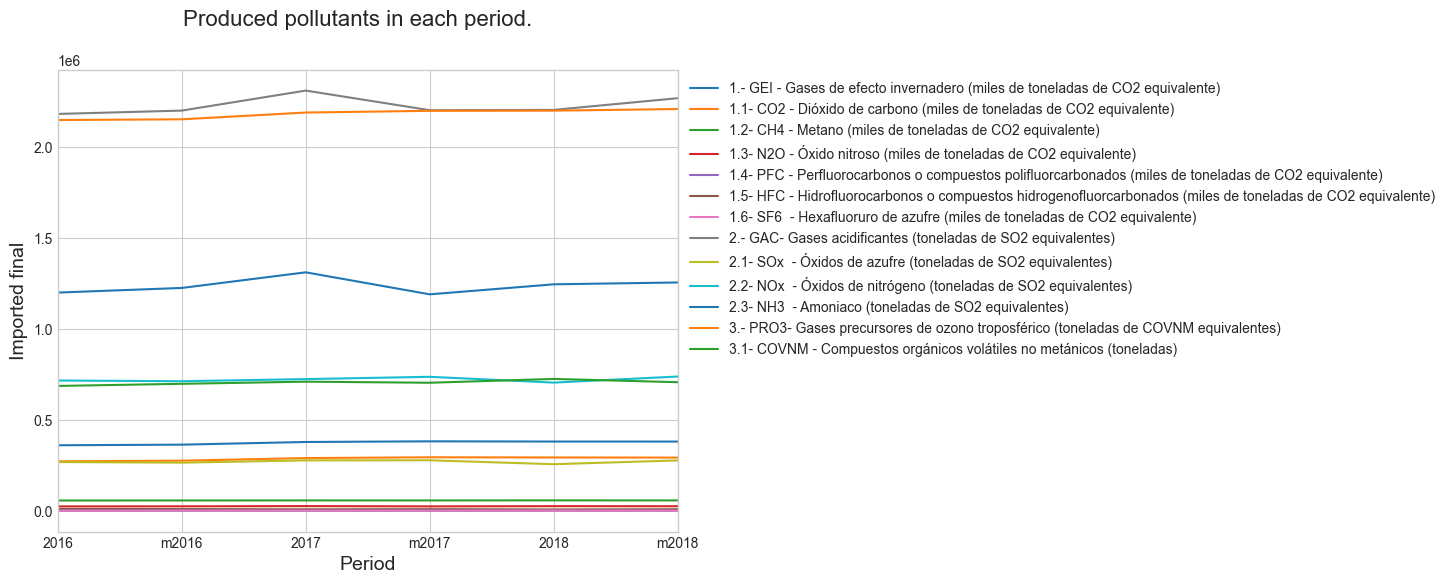

In [29]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
fig.suptitle('Produced pollutants in each period.', size = 16)

for i in range(len(ecology.pollutant_names)):
    ax.plot(periods[: plan.periods], pollutants[i, :], label=ecology.pollutant_names[i])

plan_lims = ax.set_xlim(periods[0], periods[plan.periods - 1])
ax.set_xlabel('Period', size = 14)
ax.set_ylabel('Pollutant', size = 14)
ax.legend(bbox_to_anchor=(1, 1))

plt.savefig(Path('figures', 'pollutants.png'))